In [1]:
#import trainer
#import data_loader

import tensorflow as tf
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab

In [2]:
class DataLoader():
    def __init__(self, train_path, test_path):
        self.train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
        self.test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

    def load_data(self, num_words=10000):
        tokenizer = Mecab()
        stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
        self.train_data.drop_duplicates(subset=['document'], inplace=True)
        self.train_data = self.train_data.dropna(how='any')
        self.test_data.drop_duplicates(subset=['document'], inplace=True)
        self.test_data = self.test_data.dropna(how='any')

        X_train = []
        for sentence in self.train_data['document']:
            temp_X = tokenizer.morphs(sentence)  # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
            X_train.append(temp_X)

        X_test = []
        for sentence in self.test_data['document']:
            temp_X = tokenizer.morphs(sentence)  # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
            X_test.append(temp_X)

        words = np.concatenate(X_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(num_words - 4)
        vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
        self.word_to_index = {word: index for index, word in enumerate(vocab)}

        def wordlist_to_indexlist(wordlist):
            return [self.word_to_index[word] if word in self.word_to_index else self.word_to_index['<UNK>'] for word in wordlist]

        self.X_train = list(map(wordlist_to_indexlist, X_train))
        self.X_test = list(map(wordlist_to_indexlist, X_test))
        self.Y_train = np.array(list(self.train_data['label']))
        self.Y_test = np.array(list(self.test_data['label']))
        self.tokenizer = tokenizer
        self.counter = counter
        self.vocab = vocab

    def get_maxlen(self):
        total_data_text = list(self.X_train) + list(self.X_test)
        # 텍스트데이터 문장길이의 리스트를 생성한 후
        num_tokens = [len(tokens) for tokens in total_data_text]
        num_tokens = np.array(num_tokens)
        # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
        print('문장길이 평균 : ', np.mean(num_tokens))
        print('문장길이 최대 : ', np.max(num_tokens))
        print('문장길이 표준편차 : ', np.std(num_tokens))

        # 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
        max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
        self.maxlen = int(max_tokens)
        print('pad_sequences maxlen : ', self.maxlen)
        print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))
        return self.maxlen

    def set_pad(self, padding='post'):
        self.X_train = keras.preprocessing.sequence.pad_sequences(self.X_train,
                                                             value=self.word_to_index["<PAD>"],
                                                             padding='post',  # 혹은 'pre'
                                                             maxlen=self.maxlen)

        self.X_test = keras.preprocessing.sequence.pad_sequences(self.X_test,
                                                            value=self.word_to_index["<PAD>"],
                                                            padding='post',  # 혹은 'pre'
                                                            maxlen=self.maxlen)
        return self.X_train, self.X_test

    def get_data(self, train_idx=30000):
        x_train = self.X_train[:train_idx]
        x_val = self.X_train[train_idx:]

        y_train = self.Y_train[:train_idx]
        y_val = self.Y_train[train_idx:]

        return x_train, y_train, x_val, y_val, self.X_test, self.Y_test

    def get_tokenizer(self):
        return self.tokenizer
    
    def get_counter(self):
        return self.counter

    def get_word_to_index(self):
        return self.word_to_index

    def get_vocab(self):
        return self.vocab

In [3]:
from sklearn.model_selection import train_test_split

class Trainer():
    def data_split(self, src_data, tgt_data,  val_size = 0.2, test_size = 0.2):
        x_data, self.test_x, y_data, self.test_y = train_test_split(src_data, tgt_data, test_size=test_size)
        self.train_x, self.val_x, self.train_y, self.val_y = train_test_split(x_data, y_data, test_size=val_size)

    def train(self, model, optimizer, loss, epochs=100, batch_size=512, verbose=2):
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        self.hist = model.fit(self.train_x, self.train_y, epochs=epochs, batch_size=batch_size, validation_data=(self.val_x, self.val_y), verbose=verbose)

    def test(self, model):
        test_loss, test_acc = model.evaluate(self.test_x, self.test_y)
        print("test_loss    :{}".format(test_loss))
        print("test_accuracy:{}".format(test_acc))

    def visualization(self):
        history_dict = self.hist.history
        
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 8))

        # loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

In [4]:
train_path = '~/aiffel/sentiment_classification/data/ratings_train.txt'
test_path = '~/aiffel/sentiment_classification/data/ratings_test.txt'

In [5]:
data_loader = DataLoader(train_path, test_path)

In [6]:
num_words = 10000
data_loader.load_data(num_words)
data_loader.get_maxlen()
data_loader.set_pad('post')
x_train, y_train , x_val, y_val, x_test, y_test = data_loader.get_data(train_idx=130000)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [33]:
trainer = Trainer()

In [34]:
trainer.train_x = x_train
trainer.val_x = x_val
trainer.test_x = x_test
trainer.train_y = y_train
trainer.val_y = y_val
trainer.test_y = y_test

In [175]:
print(x_train.shape)
print(x_train[0])
print(x_train[0].shape)
#print(keras.layers.Input(shape=(41,)))
#print(keras.layers.Embedding(100, 25)(x_train).shape)

(130000, 41)
[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
(41,)


In [26]:
x = keras.layers.Embedding(10001, 24)(x_train)
x.shape

TensorShape([130000, 41, 24])

In [121]:
x_train[4]

array([   2, 8894, 1108,   52, 2832,   60,    5,   14, 2758,   41, 1188,
         35,  351,   42,   22,   40,   60,    2,    2,  427, 3102, 1766,
          6,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

# Base Model
LSTM Model

In [49]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 25

lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
lstm_model.add(keras.layers.LSTM(256, activation = 'relu'))
lstm_model.add(keras.layers.Dense(256, activation='relu'))
lstm_model.add(keras.layers.Dense(128, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 25)          250000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               288768    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 637,585
Trainable params: 637,585
Non-trainable params: 0
_________________________________________________________________


In [50]:
trainer.train(model=lstm_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
59/59 - 12s - loss: 0.6907 - accuracy: 0.5182 - val_loss: 0.6925 - val_accuracy: 0.5173
Epoch 2/10
59/59 - 10s - loss: 0.5721 - accuracy: 0.7151 - val_loss: 36.8145 - val_accuracy: 0.8052
Epoch 3/10
59/59 - 10s - loss: 0.3819 - accuracy: 0.8427 - val_loss: 0.7106 - val_accuracy: 0.8241
Epoch 4/10
59/59 - 10s - loss: 0.3021 - accuracy: 0.8794 - val_loss: 0.4515 - val_accuracy: 0.8273
Epoch 5/10
59/59 - 10s - loss: 0.2599 - accuracy: 0.9006 - val_loss: 0.4437 - val_accuracy: 0.8224
Epoch 6/10
59/59 - 10s - loss: 0.2341 - accuracy: 0.9138 - val_loss: 0.5034 - val_accuracy: 0.8191
Epoch 7/10
59/59 - 10s - loss: 0.2200 - accuracy: 0.9209 - val_loss: 0.4714 - val_accuracy: 0.8167
Epoch 8/10
59/59 - 10s - loss: 0.2075 - accuracy: 0.9266 - val_loss: 0.5603 - val_accuracy: 0.8123
Epoch 9/10
59/59 - 10s - loss: 0.1888 - accuracy: 0.9343 - val_loss: 0.5203 - val_accuracy: 0.8114
Epoch 10/10
59/59 - 10s - loss: 0.1763 - accuracy: 0.9396 - val_loss: 0.5406 - val_accuracy: 0.8047


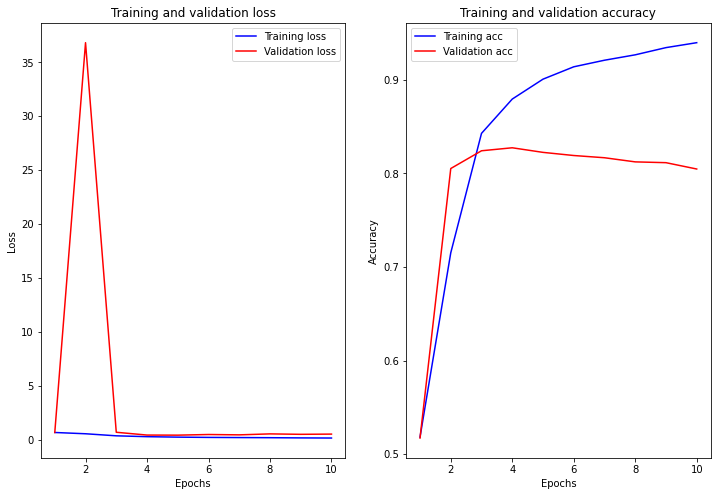

1537/1537 [==============================] - 13s 9ms/step - loss: 0.5399 - accuracy: 0.8044
test_loss    :0.5399380326271057
test_accuracy:0.8043819069862366


In [51]:
trainer.visualization()
trainer.test(lstm_model)

# Attention model  
## First try  - fail with accuracy 50%

In [52]:
input_dim = 41

# input layer
inputs = keras.layers.Input(shape=(input_dim,))

# attention layer
attention_probs = keras.layers.Dense(input_dim, activation='softmax')(inputs)
attention_mul = keras.layers.multiply([inputs, attention_probs])

# fc layer
fc = keras.layers.Dense(64)(attention_mul)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_model = keras.Model(inputs=[inputs], outputs=output)

attention_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 41)           1722        input_6[0][0]                    
__________________________________________________________________________________________________
multiply_5 (Multiply)           (None, 41)           0           input_6[0][0]                    
                                                                 dense_25[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 64)           2688        multiply_5[0][0]           

In [53]:
trainer.train(model=attention_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
59/59 - 1s - loss: 3.8383 - accuracy: 0.5007 - val_loss: 1.1788 - val_accuracy: 0.5031
Epoch 2/10
59/59 - 0s - loss: 1.1680 - accuracy: 0.5035 - val_loss: 0.9787 - val_accuracy: 0.5025
Epoch 3/10
59/59 - 0s - loss: 1.0275 - accuracy: 0.5000 - val_loss: 1.0376 - val_accuracy: 0.5035
Epoch 4/10
59/59 - 0s - loss: 1.0459 - accuracy: 0.4965 - val_loss: 1.0164 - val_accuracy: 0.5037
Epoch 5/10
59/59 - 0s - loss: 0.9398 - accuracy: 0.5031 - val_loss: 0.9868 - val_accuracy: 0.5033
Epoch 6/10
59/59 - 0s - loss: 0.9504 - accuracy: 0.5015 - val_loss: 0.9800 - val_accuracy: 0.4987
Epoch 7/10
59/59 - 0s - loss: 1.0979 - accuracy: 0.5032 - val_loss: 1.0557 - val_accuracy: 0.5025
Epoch 8/10
59/59 - 0s - loss: 0.9490 - accuracy: 0.5031 - val_loss: 1.0135 - val_accuracy: 0.5046
Epoch 9/10
59/59 - 0s - loss: 0.9460 - accuracy: 0.4975 - val_loss: 0.9398 - val_accuracy: 0.4984
Epoch 10/10
59/59 - 0s - loss: 0.9579 - accuracy: 0.4963 - val_loss: 0.8848 - val_accuracy: 0.5010


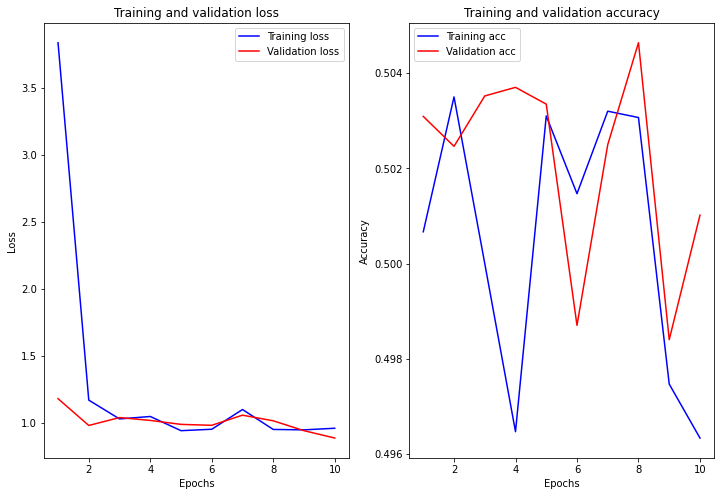

In [54]:
trainer.visualization()

In [55]:
trainer.test(attention_model)


1537/1537 [==============================] - 3s 2ms/step - loss: 0.8821 - accuracy: 0.5062
test_loss    :0.8821205496788025
test_accuracy:0.5062147974967957


# Attention model  
## Second try - fail with accuracy 50%

In [63]:
vocab_size = 10000   
word_vector_dim = 25
input_dim = 41

# input layer
inputs = keras.layers.Input(shape=(input_dim,))

# attention layer
attention_probs = keras.layers.Dense(input_dim, activation='softmax')(inputs)
attention_mul = keras.layers.multiply([inputs, attention_probs])

embed_layer = keras.layers.Embedding(vocab_size, word_vector_dim)(attention_mul)

# lstm layer
lstm_layer = keras.layers.LSTM(256, activation='relu')(embed_layer)

# fc layer
fc = keras.layers.Dense(64)(lstm_layer)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_lstm_model = keras.Model(inputs=[inputs], outputs=output)

attention_lstm_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 41)           1722        input_11[0][0]                   
__________________________________________________________________________________________________
multiply_10 (Multiply)          (None, 41)           0           input_11[0][0]                   
                                                                 dense_38[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 41, 25)       250000      multiply_10[0][0]          

In [60]:
trainer.train(model=attention_lstm_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
59/59 - 12s - loss: 0.6933 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 2/10
59/59 - 10s - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 3/10
59/59 - 10s - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 4/10
59/59 - 10s - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 5/10
59/59 - 10s - loss: 0.6942 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 6/10
59/59 - 10s - loss: 0.6928 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 7/10
59/59 - 10s - loss: 0.6936 - accuracy: 0.5049 - val_loss: 0.6933 - val_accuracy: 0.5022
Epoch 8/10
59/59 - 10s - loss: 0.6924 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 9/10
59/59 - 10s - loss: 0.6921 - accuracy: 0.5041 - val_loss: 0.6932 - val_accuracy: 0.5021
Epoch 10/10
59/59 - 10s - loss: 0.8330 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.5015


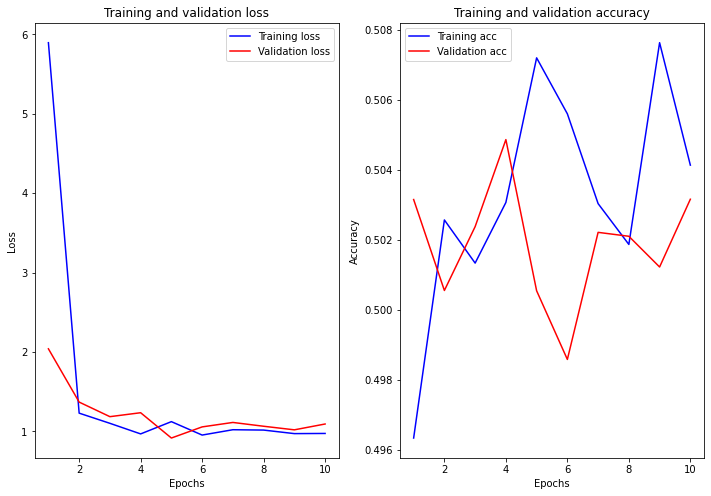

1537/1537 [==============================] - 3s 2ms/step - loss: 1.0901 - accuracy: 0.5086
test_loss    :1.0901055335998535
test_accuracy:0.508615255355835


In [58]:
trainer.visualization()
trainer.test(attention_model)

# Attention Model 
## Third try - success with accuracy 83%
## Attention before LSTM

In [51]:
vocab_size = 10000   
word_vector_dim = 25
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)

# attention layer
# inputs.shape = (batch_size, time_steps, input_dim)

a = keras.layers.Permute((2, 1))(embed) # same transpose
#a = tf.keras.layers.Reshape((input_dim, TIME_STEPS))(a) 
# this line is not useful. It's just to know which dimension is what.
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
output_attention_mul  = keras.layers.multiply([embed, a_probs])


# lstm layer
lstm_out = keras.layers.LSTM(256, return_sequences=True, activation='relu')(output_attention_mul)

# fc layer
fc = keras.layers.Dense(64)(lstm_out)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_3d_model = keras.Model(inputs=[inputs], outputs=output)

attention_3d_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 41, 25)       250000      input_9[0][0]                    
__________________________________________________________________________________________________
permute_12 (Permute)            (None, 25, 41)       0           embedding_16[0][0]               
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 25, 41)       1722        permute_12[0][0]                 
___________________________________________________________________________________________

In [52]:
trainer.train(model=attention_3d_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)
trainer.test(attention_3d_model)

Epoch 1/10
254/254 - 27s - loss: 0.6449 - accuracy: 0.5910 - val_loss: 0.4969 - val_accuracy: 0.7661
Epoch 2/10
254/254 - 25s - loss: 0.4175 - accuracy: 0.8074 - val_loss: 0.4055 - val_accuracy: 0.8120
Epoch 3/10
254/254 - 25s - loss: 0.3794 - accuracy: 0.8283 - val_loss: 0.3925 - val_accuracy: 0.8202
Epoch 4/10
254/254 - 25s - loss: 0.3629 - accuracy: 0.8368 - val_loss: 0.3873 - val_accuracy: 0.8234
Epoch 5/10
254/254 - 25s - loss: 0.3480 - accuracy: 0.8442 - val_loss: 0.3776 - val_accuracy: 0.8288
Epoch 6/10
254/254 - 25s - loss: 0.3308 - accuracy: 0.8532 - val_loss: 0.3801 - val_accuracy: 0.8320
Epoch 7/10
254/254 - 25s - loss: 0.3132 - accuracy: 0.8629 - val_loss: 0.3677 - val_accuracy: 0.8378
Epoch 8/10
254/254 - 26s - loss: 0.2959 - accuracy: 0.8724 - val_loss: 0.3725 - val_accuracy: 0.8397
Epoch 9/10
254/254 - 25s - loss: 0.2804 - accuracy: 0.8805 - val_loss: 0.3823 - val_accuracy: 0.8398
Epoch 10/10
254/254 - 25s - loss: 0.2627 - accuracy: 0.8903 - val_loss: 0.3779 - val_accura

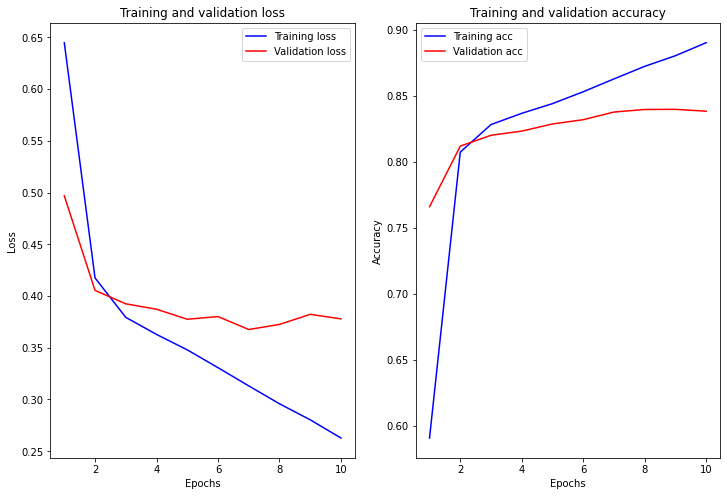

In [54]:
trainer.visualization()

In [47]:
def view_attention_vector(model, test_x, i):
	layer_outputs    = [layer.output for layer in model.layers if layer.name == 'attention_vec']
	activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
	output_data = activation_model.predict(test_x)
	output_data = keras.layers.Permute((2, 1))(output_data)
	print(output_data[i].shape)
	attention_vector = np.mean(output_data[i], axis=0)
	df = pd.DataFrame(attention_vector.transpose(), columns=['attention (%)'])
	df.plot.bar()

(25, 41)


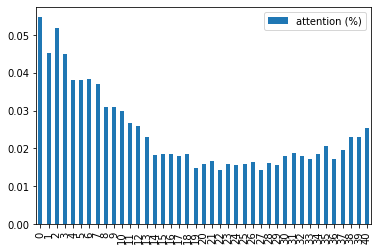

In [55]:
view_attention_vector(attention_3d_model, x_test, 3)

# Attention model
## fourth try - succes with accuracy 83% 
## Attention after LSTM

In [47]:
vocab_size = 10000   
word_vector_dim = 25
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)

# lstm layer
lstm_out = keras.layers.LSTM(256, return_sequences=True, activation='relu')(embed)

# attention layer
a = keras.layers.Permute((2, 1))(lstm_out)
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
attention_mul = keras.layers.multiply([lstm_out, a_probs])

# fc layer
fc = keras.layers.Dense(64)(attention_mul)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

Att_after_LSTM = keras.Model(inputs=[inputs], outputs=output)

Att_after_LSTM.summary()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 41, 25)       250000      input_8[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 41, 256)      288768      embedding_15[0][0]               
__________________________________________________________________________________________________
permute_10 (Permute)            (None, 256, 41)      0           lstm_10[0][0]                    
____________________________________________________________________________________________

In [48]:
trainer.train(model=Att_after_LSTM, optimizer='adam', loss='binary_crossentropy', epochs=15, verbose=2)
trainer.test(Att_after_LSTM)

Epoch 1/15
254/254 - 30s - loss: 0.5359 - accuracy: 0.7102 - val_loss: 0.4134 - val_accuracy: 0.8097
Epoch 2/15
254/254 - 28s - loss: 0.3782 - accuracy: 0.8293 - val_loss: 0.3808 - val_accuracy: 0.8285
Epoch 3/15
254/254 - 28s - loss: 0.3450 - accuracy: 0.8485 - val_loss: 0.3656 - val_accuracy: 0.8417
Epoch 4/15
254/254 - 29s - loss: 0.3153 - accuracy: 0.8675 - val_loss: 0.3542 - val_accuracy: 0.8471
Epoch 5/15
254/254 - 28s - loss: 0.2884 - accuracy: 0.8804 - val_loss: 0.3494 - val_accuracy: 0.8558
Epoch 6/15
254/254 - 28s - loss: 0.2675 - accuracy: 0.8905 - val_loss: 0.3374 - val_accuracy: 0.8568
Epoch 7/15
254/254 - 28s - loss: 0.2485 - accuracy: 0.8996 - val_loss: 0.3521 - val_accuracy: 0.8534
Epoch 8/15
254/254 - 28s - loss: 0.2316 - accuracy: 0.9076 - val_loss: 0.3697 - val_accuracy: 0.8479
Epoch 9/15
254/254 - 28s - loss: 0.2174 - accuracy: 0.9143 - val_loss: 0.3952 - val_accuracy: 0.8513
Epoch 10/15
254/254 - 28s - loss: 0.2075 - accuracy: 0.9186 - val_loss: 0.4111 - val_accura

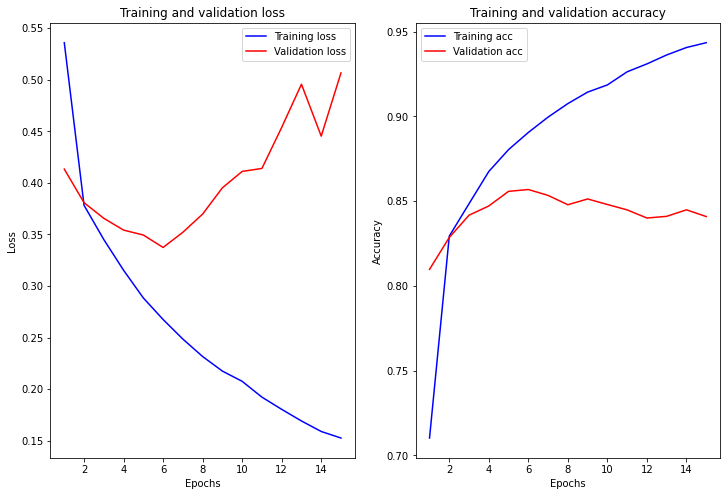

In [49]:
trainer.visualization()

(256, 41)


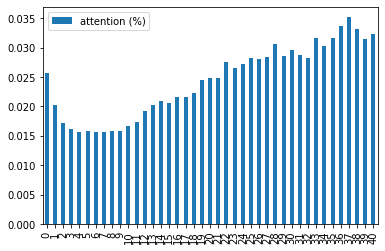

In [56]:
view_attention_vector(Att_after_LSTM, x_test, 3)

# Transformer

In [158]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = keras.layers.Dense(embedding_dim)
        self.key_dense = keras.layers.Dense(embedding_dim)
        self.value_dense = keras.layers.Dense(embedding_dim)
        self.dense = keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [159]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(dff, activation="relu"),
             keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [160]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = range(0, max_len, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [178]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기
vocab_size = 10000
max_len = 41

inputs = keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(20, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

transformer = keras.Model(inputs=inputs, outputs=outputs)
transformer.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
token_and_position_embedding (None, 41, 32)            321312    
_________________________________________________________________
transformer_block_7 (Transfo (None, 41, 32)            6464      
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 20)                660       
_________________________________________________________________
dropout_27 (Dropout)         (None, 20)                0  

In [179]:
trainer.train(model=transformer, optimizer='adam', loss='binary_crossentropy', epochs=5, verbose=2)

Epoch 1/5
254/254 - 7s - loss: 0.4633 - accuracy: 0.7726 - val_loss: 0.3523 - val_accuracy: 0.8450
Epoch 2/5
254/254 - 5s - loss: 0.3393 - accuracy: 0.8550 - val_loss: 0.3486 - val_accuracy: 0.8475
Epoch 3/5
254/254 - 5s - loss: 0.3221 - accuracy: 0.8618 - val_loss: 0.3474 - val_accuracy: 0.8468
Epoch 4/5
254/254 - 5s - loss: 0.3072 - accuracy: 0.8661 - val_loss: 0.3521 - val_accuracy: 0.8469
Epoch 5/5
254/254 - 5s - loss: 0.2924 - accuracy: 0.8693 - val_loss: 0.3597 - val_accuracy: 0.8440


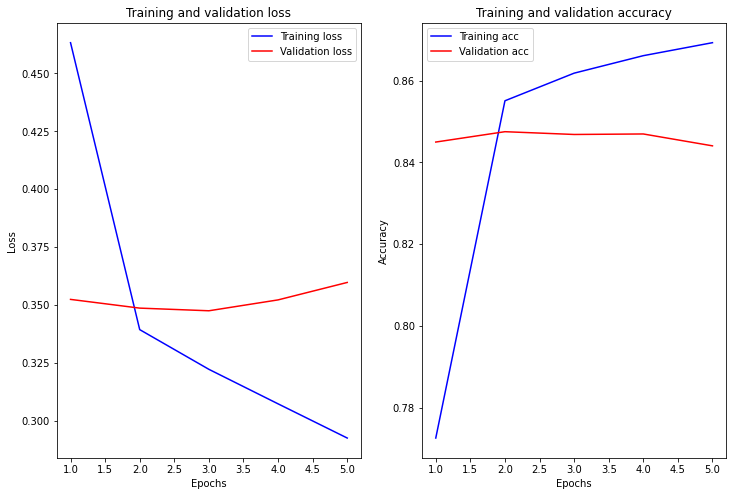

1537/1537 [==============================] - 6s 4ms/step - loss: 0.3635 - accuracy: 0.8440
test_loss    :0.3634662926197052
test_accuracy:0.8439693450927734


In [180]:
trainer.visualization()
trainer.test(transformer)

# Self Attention

In [62]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19415 sha256=d887d918079803f8b6cac958dffcfc3721918580a56c6897e68f3198b9ddf970
  Stored in directory: /aiffel/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [63]:
from keras_self_attention import SeqSelfAttention

embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기
vocab_size = 10000
max_len = 41

In [22]:
SelfAttention = keras.Sequential()
SelfAttention.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len))
#SelfAttention.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, activation='relu')))
SelfAttention.add(keras.layers.LSTM(256, return_sequences=True, activation='relu'))
SelfAttention.add(SeqSelfAttention(attention_activation='sigmoid'))
SelfAttention.add(keras.layers.Dense(1, activation='sigmoid'))

SelfAttention.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 32)            320000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 41, 256)           295936    
_________________________________________________________________
seq_self_attention_4 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           257       
Total params: 632,642
Trainable params: 632,642
Non-trainable params: 0
_________________________________________________________________


In [23]:
trainer.train(model=SelfAttention, optimizer='adam', loss='binary_crossentropy', epochs=8, verbose=2)

Epoch 1/8
254/254 - 32s - loss: 0.5161 - accuracy: 0.7251 - val_loss: 0.3713 - val_accuracy: 0.8393
Epoch 2/8
254/254 - 29s - loss: 0.3420 - accuracy: 0.8535 - val_loss: 0.3526 - val_accuracy: 0.8464
Epoch 3/8
254/254 - 29s - loss: 0.3132 - accuracy: 0.8670 - val_loss: 0.3456 - val_accuracy: 0.8506
Epoch 4/8
254/254 - 29s - loss: 0.2865 - accuracy: 0.8775 - val_loss: 0.3377 - val_accuracy: 0.8543
Epoch 5/8
254/254 - 29s - loss: 0.2631 - accuracy: 0.8893 - val_loss: 0.3550 - val_accuracy: 0.8556
Epoch 6/8
254/254 - 29s - loss: 0.2451 - accuracy: 0.8962 - val_loss: 0.3621 - val_accuracy: 0.8536
Epoch 7/8
254/254 - 29s - loss: 0.2279 - accuracy: 0.9042 - val_loss: 0.3684 - val_accuracy: 0.8472
Epoch 8/8
254/254 - 29s - loss: 0.2133 - accuracy: 0.9105 - val_loss: 0.4078 - val_accuracy: 0.8536


1537/1537 [==============================] - 15s 10ms/step - loss: 0.4142 - accuracy: 0.8504
test_loss    :0.4142204821109772
test_accuracy:0.8504419922828674


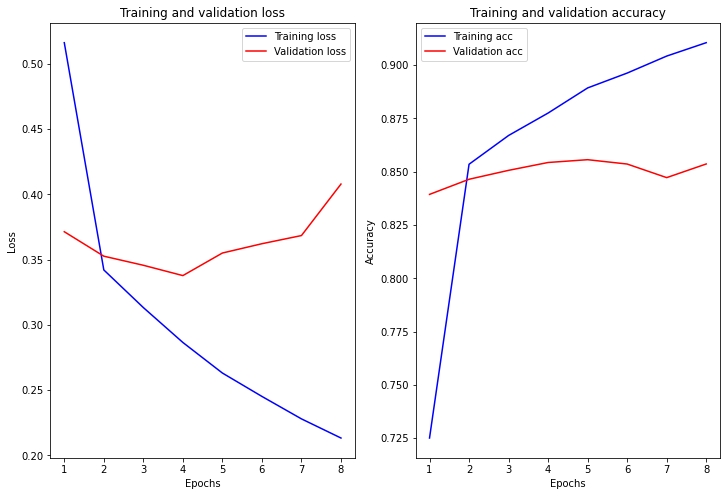

In [24]:
trainer.test(SelfAttention)
trainer.visualization()

# Word Embedding - Word2Vec

In [3]:
!pip freeze

absl-py==0.10.0
aiohttp==3.7.3
aiohttp-cors==0.7.0
aioredis==1.3.1
albumentations==0.5.2
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388745313/work/dist
appdirs==1.4.4
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522577486/work
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
audioread==2.1.9
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
beautifulsoup4==4.6.0
bleach==3.2.1
blessings==1.7
brotlipy==0.7.0
cachetools==4.2.0
certifi==2020.12.5
cffi==1.14.4
chardet==3.0.4
click==7.1.2
cmake==3.18.4.post1
colorama==0.4.4
colorful==0.5.4
conda==4.10.1
conda-build==3.21.4
conda-package-handling @ file:///home/conda/feedstock_root/build_artifacts/conda-package-handling_1618231393684/work
cryptography==3.3.1
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
deprecat

In [1]:
!pip install --upgrade gensim==3.8.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
import gensim

word2vec_model = gensim.models.Word2Vec.load('./aiffel/sentiment_classification/ko.bin')

In [8]:
word2vec_model.wv.most_similar("코딩")

[('포맷', 0.6343257427215576),
 ('코덱', 0.6217125654220581),
 ('입출력', 0.5991847515106201),
 ('컴파일', 0.5987979173660278),
 ('암호화', 0.5883111953735352),
 ('동적', 0.5734175443649292),
 ('오디오', 0.5673085451126099),
 ('입력', 0.5627327561378479),
 ('헤더', 0.5625399947166443),
 ('압축', 0.5619621276855469)]

In [11]:
word2vec_model["코딩"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 3.61494064e-01, -6.94217503e-01, -6.02033198e-01,  2.31722131e-01,
        5.49535453e-01,  9.71483648e-01, -1.01636744e+00,  7.23703742e-01,
        1.47924745e+00, -9.13086653e-01, -1.93459660e-01,  1.35856831e+00,
        5.01642227e-01, -1.94982934e+00,  3.20488177e-02,  1.08824790e-01,
       -1.18106902e+00,  6.52160466e-01,  6.77897334e-01, -8.59361172e-01,
        4.65325490e-02, -3.01321477e-01, -9.71701980e-01,  5.25678933e-01,
        1.86362922e+00, -1.45405805e+00, -3.06942034e+00, -1.02401925e-02,
        6.11216664e-01, -7.73372591e-01,  1.15418994e+00,  8.06326568e-01,
        8.44107807e-01,  1.65869153e+00, -1.79672444e+00,  1.54569125e+00,
       -1.51751888e+00, -7.14774013e-01,  2.31724143e+00, -2.08635673e-01,
       -7.14168489e-01, -1.35619128e+00,  6.46624386e-01, -7.41990387e-01,
        1.15963416e-02,  1.58453262e+00, -6.33664250e-01, -1.59736574e+00,
        5.62700987e-01, -2.12479234e+00, -1.45227480e+00,  1.36099830e-01,
        6.13757670e-01, -

In [16]:
vocab = data_loader.get_vocab()
print(len(vocab))
vocab

10000


['<PAD>',
 '<BOS>',
 '<UNK>',
 '<UNUSED>',
 '.',
 '영화',
 '다',
 '고',
 '하',
 '을',
 '보',
 '..',
 '게',
 ',',
 '!',
 '지',
 '있',
 '없',
 '?',
 '좋',
 '나',
 '었',
 '만',
 '는데',
 '너무',
 '봤',
 '적',
 '안',
 '정말',
 '로',
 '음',
 '것',
 '아',
 '네요',
 '재밌',
 '어',
 '같',
 '점',
 '지만',
 '진짜',
 '했',
 '에서',
 '기',
 '네',
 '않',
 '거',
 '았',
 '수',
 '되',
 '면',
 'ㅋㅋ',
 '말',
 '연기',
 '인',
 '주',
 '내',
 '최고',
 '~',
 '평점',
 '이런',
 '던',
 '어요',
 '할',
 '왜',
 '겠',
 '1',
 '스토리',
 '해',
 '습니다',
 'ㅋㅋㅋ',
 '...',
 '드라마',
 '생각',
 '아니',
 '더',
 '그',
 '싶',
 '사람',
 '듯',
 '때',
 '감동',
 '함',
 '배우',
 '본',
 '까지',
 '뭐',
 '알',
 '만들',
 '내용',
 '볼',
 '감독',
 '보다',
 '라',
 '그냥',
 '재미',
 '시간',
 '지루',
 '중',
 '재미있',
 '년',
 '10',
 '였',
 '잼',
 '사랑',
 '못',
 '냐',
 '재미없',
 '쓰레기',
 '서',
 '2',
 '라고',
 '야',
 '니',
 '면서',
 '번',
 '다시',
 '나오',
 '작품',
 '이거',
 '하나',
 '줄',
 '해서',
 '개',
 '남',
 '정도',
 '마지막',
 '끝',
 '이건',
 '액션',
 '임',
 'ㅋ',
 '3',
 '기대',
 '입니다',
 '건',
 '라는',
 '분',
 '완전',
 '다는',
 '참',
 '많',
 '처음',
 '장면',
 '대',
 '아깝',
 '다가',
 '으면',
 '지금',
 '모르',
 '이렇게',
 "'",

In [17]:
vocab_size = num_words

embedding_matrix=np.zeros((vocab_size, 200))
print(np.shape(embedding_matrix))

(10000, 200)


In [12]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [26]:
get_vector(vocab[5])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [40]:
w2i = data_loader.get_word_to_index()
w2i

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [18]:
for i, word in enumerate(vocab):
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
embedding_matrix[5]

array([-1.75778365, -1.08742785,  1.53008664, -0.1115231 , -0.37980682,
        1.48285174,  1.31804192,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.57639128,  1.21070695,  1.31327951, -0.86962503,
       -0.18507595, -0.47440064,  1.51007247,  1.09657943,  1.06008232,
       -0.27457932, -0.70003706,  2.31175113,  1.49448836,  0.25560892,
       -2.86665893, -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.31847739,
        0.5271619 ,  0.7561084 , -2.12470651,  1.06142902, -0.21065854,
        0.68773431, -1.49563825,  0.60346967, -2.6955893 ,  0.37694618,
       -1.01641846,  0.54306632,  0.1200121 , -2.63157177,  0.62167418,
        1.15839756, -2.53859615,  1.32631195, -0.10284371, -0.0286147 ,
       -0.91329467,  0.76475638,  0.79202783, -1.86259568, -0.74183953,
        0.58842772, -0.99179918, -0.62114453,  1.53678155, -0.66289389,
        0.67121029,  0.12914915,  0.21228492,  0.90176553, -0.25

# LSTM Model with word2vec

In [39]:
vocab_size = 10000
word_vector_dim = 200

lstm_vec_model = keras.Sequential()
lstm_vec_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False))
lstm_vec_model.add(keras.layers.LSTM(128, activation = 'relu'))
lstm_vec_model.add(keras.layers.Dense(256, activation='relu'))
lstm_vec_model.add(keras.layers.Dense(128, activation='relu'))
lstm_vec_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_vec_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 2,234,497
Trainable params: 234,497
Non-trainable params: 2,000,000
_________________________________________________________________


In [40]:
trainer.train(model=lstm_vec_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 22s - loss: 0.5730 - accuracy: 0.6860 - val_loss: 0.4590 - val_accuracy: 0.7817
Epoch 2/10
254/254 - 20s - loss: 0.4367 - accuracy: 0.7958 - val_loss: 0.4190 - val_accuracy: 0.8015
Epoch 3/10
254/254 - 20s - loss: 0.3937 - accuracy: 0.8187 - val_loss: 0.4042 - val_accuracy: 0.8103
Epoch 4/10
254/254 - 20s - loss: 0.3706 - accuracy: 0.8314 - val_loss: 0.3889 - val_accuracy: 0.8152
Epoch 5/10
254/254 - 20s - loss: 0.3521 - accuracy: 0.8422 - val_loss: 0.3877 - val_accuracy: 0.8210
Epoch 6/10
254/254 - 19s - loss: 0.3373 - accuracy: 0.8487 - val_loss: 0.3819 - val_accuracy: 0.8220
Epoch 7/10
254/254 - 19s - loss: 0.3283 - accuracy: 0.8539 - val_loss: 0.3818 - val_accuracy: 0.8239
Epoch 8/10
254/254 - 19s - loss: 0.3089 - accuracy: 0.8640 - val_loss: 0.3894 - val_accuracy: 0.8258
Epoch 9/10
254/254 - 19s - loss: 0.2933 - accuracy: 0.8720 - val_loss: 0.3895 - val_accuracy: 0.8252
Epoch 10/10
254/254 - 19s - loss: 0.2773 - accuracy: 0.8798 - val_loss: 0.4032 - val_accura

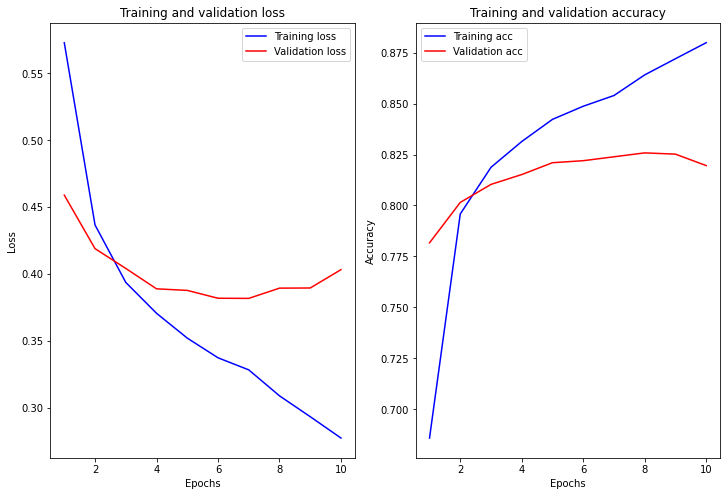

1537/1537 [==============================] - 13s 8ms/step - loss: 0.4122 - accuracy: 0.8175
test_loss    :0.4122311472892761
test_accuracy:0.8174827694892883


In [41]:
trainer.visualization()
trainer.test(lstm_vec_model)

# Attention_before_LSTM Model with Word2Vec 

In [43]:
vocab_size = 10000   
word_vector_dim = 200
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False)(inputs)

# attention layer
# inputs.shape = (batch_size, time_steps, input_dim)
a = keras.layers.Permute((2, 1))(embed) 
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
output_attention_mul  = keras.layers.multiply([embed, a_probs])


# lstm layer
lstm_out = keras.layers.LSTM(256, return_sequences=True, activation='relu')(output_attention_mul)

# fc layer
fc = keras.layers.Dense(64)(lstm_out)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

Att_before_LSTM_vec_model = keras.Model(inputs=[inputs], outputs=output)

Att_before_LSTM_vec_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 41, 200)      2000000     input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 200, 41)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 200, 41)      1722        permute_1[0][0]                  
______________________________________________________________________________________________

In [44]:
trainer.train(model=Att_before_LSTM_vec_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 30s - loss: 0.5942 - accuracy: 0.6772 - val_loss: 0.5367 - val_accuracy: 0.7291
Epoch 2/10
254/254 - 28s - loss: 0.5097 - accuracy: 0.7435 - val_loss: 0.4991 - val_accuracy: 0.7492
Epoch 3/10
254/254 - 28s - loss: 0.4717 - accuracy: 0.7662 - val_loss: 0.4854 - val_accuracy: 0.7643
Epoch 4/10
254/254 - 28s - loss: 0.4512 - accuracy: 0.7789 - val_loss: 0.4597 - val_accuracy: 0.7783
Epoch 5/10
254/254 - 28s - loss: 0.4360 - accuracy: 0.7897 - val_loss: 0.4495 - val_accuracy: 0.7831
Epoch 6/10
254/254 - 28s - loss: 0.4211 - accuracy: 0.7983 - val_loss: 0.4554 - val_accuracy: 0.7846
Epoch 7/10
254/254 - 28s - loss: 0.4103 - accuracy: 0.8047 - val_loss: 0.4526 - val_accuracy: 0.7845
Epoch 8/10
254/254 - 28s - loss: 0.4002 - accuracy: 0.8105 - val_loss: 0.4614 - val_accuracy: 0.7842
Epoch 9/10
254/254 - 28s - loss: 0.3922 - accuracy: 0.8147 - val_loss: 0.4642 - val_accuracy: 0.7741
Epoch 10/10
254/254 - 28s - loss: 0.3790 - accuracy: 0.8220 - val_loss: 0.4588 - val_accura

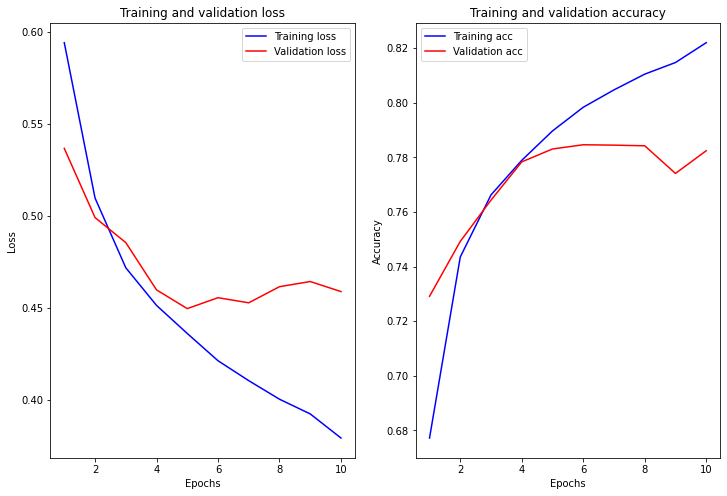

1537/1537 [==============================] - 17s 11ms/step - loss: 0.4620 - accuracy: 0.7828
test_loss    :0.4620426595211029
test_accuracy:0.7828369140625


In [45]:
trainer.visualization()
trainer.test(Att_before_LSTM_vec_model)

(200, 41)


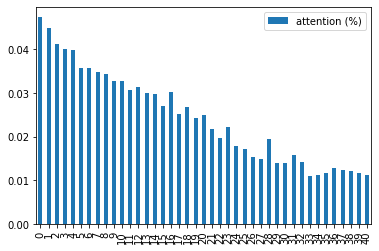

In [48]:
view_attention_vector(Att_before_LSTM_vec_model, x_test, 3)

# Attention_after_LSTM Model with Word2Vec

In [52]:
vocab_size = 10000   
word_vector_dim = 200
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False)(inputs)

# lstm layer
lstm_out = keras.layers.LSTM(256, return_sequences=True, activation='relu')(embed)

# attention layer
a = keras.layers.Permute((2, 1))(lstm_out)
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
attention_mul = keras.layers.multiply([lstm_out, a_probs])

# fc layer
fc = keras.layers.Dense(64)(attention_mul)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

Att_after_LSTM_vec = keras.Model(inputs=[inputs], outputs=output)

Att_after_LSTM_vec.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 41, 200)      2000000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 41, 256)      467968      embedding_8[0][0]                
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 256, 41)      0           lstm_5[0][0]                     
____________________________________________________________________________________________

In [54]:
trainer.train(model=Att_after_LSTM_vec, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 31s - loss: 0.6703 - accuracy: 0.6813 - val_loss: 0.8052 - val_accuracy: 0.6315
Epoch 2/10
254/254 - 30s - loss: 0.7758 - accuracy: 0.6615 - val_loss: 0.7677 - val_accuracy: 0.6712
Epoch 3/10
254/254 - 30s - loss: 0.7486 - accuracy: 0.6847 - val_loss: 0.7463 - val_accuracy: 0.6863
Epoch 4/10
254/254 - 30s - loss: 0.7298 - accuracy: 0.7002 - val_loss: 0.7295 - val_accuracy: 0.6986
Epoch 5/10
254/254 - 29s - loss: 0.7110 - accuracy: 0.7155 - val_loss: 0.7128 - val_accuracy: 0.7118
Epoch 6/10
254/254 - 28s - loss: 0.6893 - accuracy: 0.7326 - val_loss: 0.6831 - val_accuracy: 0.7380
Epoch 7/10
254/254 - 28s - loss: 0.7085 - accuracy: 0.7056 - val_loss: 0.7340 - val_accuracy: 0.6985
Epoch 8/10
254/254 - 29s - loss: 0.7160 - accuracy: 0.7128 - val_loss: 0.7091 - val_accuracy: 0.7183
Epoch 9/10
254/254 - 28s - loss: 0.6922 - accuracy: 0.7316 - val_loss: 0.6857 - val_accuracy: 0.7378
Epoch 10/10
254/254 - 28s - loss: 0.7051 - accuracy: 0.7127 - val_loss: 0.7308 - val_accura

1537/1537 [==============================] - 18s 12ms/step - loss: 0.7362 - accuracy: 0.6994
test_loss    :0.7362130880355835
test_accuracy:0.6993556022644043


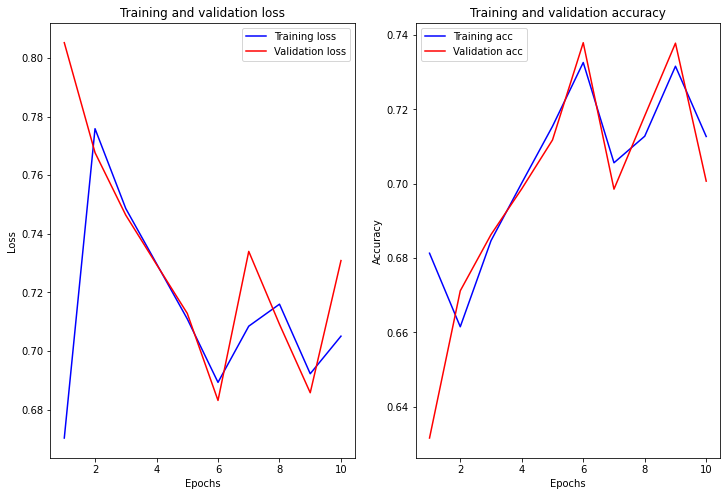

In [55]:
trainer.test(Att_after_LSTM_vec)
trainer.visualization()

In [59]:
x_test[3]

array([ 96,   8,  15,  44, 231, 137, 357, 129,   4,  11, 153,  54,   7,
        10,  42,   4,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

(256, 41)


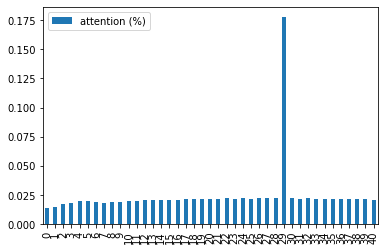

In [56]:
view_attention_vector(Att_after_LSTM_vec, x_test, 3)

# Self Attention with Word2Vec

In [68]:
SelfAttention_vec = keras.Sequential()
SelfAttention_vec.add(keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False))
#SelfAttention.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, activation='relu')))
SelfAttention_vec.add(keras.layers.LSTM(256, return_sequences=True, activation='relu'))
SelfAttention_vec.add(SeqSelfAttention(attention_activation='sigmoid'))
SelfAttention_vec.add(keras.layers.Dense(1, activation='sigmoid'))

SelfAttention_vec.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 41, 256)           467968    
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_20 (Dense)             (None, None, 1)           257       
Total params: 2,484,674
Trainable params: 484,674
Non-trainable params: 2,000,000
_________________________________________________________________


In [69]:
trainer.train(model=SelfAttention_vec, optimizer='adam', loss='binary_crossentropy', epochs=13, verbose=2)

Epoch 1/13
254/254 - 31s - loss: 0.4884 - accuracy: 0.7592 - val_loss: 0.4274 - val_accuracy: 0.7995
Epoch 2/13
254/254 - 28s - loss: 0.4010 - accuracy: 0.8143 - val_loss: 0.3975 - val_accuracy: 0.8149
Epoch 3/13
254/254 - 28s - loss: 0.3691 - accuracy: 0.8306 - val_loss: 0.3769 - val_accuracy: 0.8230
Epoch 4/13
254/254 - 29s - loss: 0.3430 - accuracy: 0.8453 - val_loss: 0.3806 - val_accuracy: 0.8262
Epoch 5/13
254/254 - 28s - loss: 0.3165 - accuracy: 0.8589 - val_loss: 0.3805 - val_accuracy: 0.8239
Epoch 6/13
254/254 - 28s - loss: 0.2927 - accuracy: 0.8713 - val_loss: 0.3850 - val_accuracy: 0.8261
Epoch 7/13
254/254 - 28s - loss: 0.2679 - accuracy: 0.8839 - val_loss: 0.3901 - val_accuracy: 0.8283
Epoch 8/13
254/254 - 28s - loss: 0.2463 - accuracy: 0.8945 - val_loss: 0.4192 - val_accuracy: 0.8215
Epoch 9/13
254/254 - 28s - loss: 0.2199 - accuracy: 0.9069 - val_loss: 0.4496 - val_accuracy: 0.8274
Epoch 10/13
254/254 - 28s - loss: 0.1977 - accuracy: 0.9168 - val_loss: 0.4799 - val_accura

1537/1537 [==============================] - 18s 11ms/step - loss: 0.5899 - accuracy: 0.8193
test_loss    :0.5899416208267212
test_accuracy:0.8193272948265076


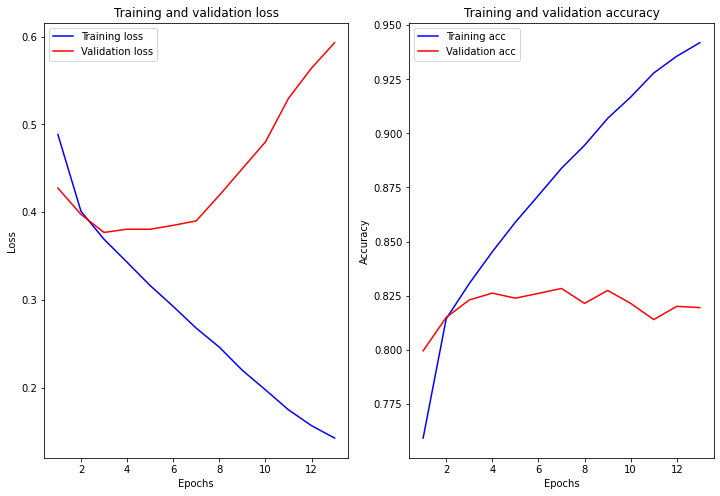

In [70]:
trainer.test(SelfAttention_vec)
trainer.visualization()